# Importing libraries

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import SubsetRandomSampler, DataLoader
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


# Loading Fashion MNIST dataset

In [ ]:
# Transformations
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

# Loading Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', 
                                                  train=True, 
                                                  download=True, 
                                                  transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', 
                                                 train=False, 
                                                 download=True, 
                                                 transform=transform)

# Defining logistic regression model

In [ ]:
input_size = 28 * 28  # Size of the Fashion MNIST images
num_classes = 10  # Number of classes in Fashion MNIST

# Logistic Regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.linear(x)
        return out

# Training the model 

(with randomly chosen hyperparameters)

In [ ]:
# Hyperparameters
learning_rate = 0.001
epochs = 5
batch_size = 32

# Split training set into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Instantiate the model
model = LogisticRegression(input_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop with validation
for epoch in range(epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 1000 == 0:
            print(f'Training - Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            # Move data to GPU
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Hyperparameter tuning using K-fold CV

## Tuning number of epochs

In [ ]:
# Hyperparameters
learning_rate = 0.01
epochs = [2, 5, 10, 15, 20]
batch_size = 32

# Initializing K-Fold
k_folds = 5  
kf = KFold(n_splits=k_folds, shuffle=True, random_state=28)

avg_val_accuracies = []

# Looping over hyperparameters
for epoch_i in epochs:
    print(f"\n5-fold CV for {epoch_i} epochs...\n")
    
    val_accuracy_list = []
    
    # Looping over folds
    for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
        print(f"Fold {fold + 1}/{k_folds}")

        # Creating DataLoader for training and validation set
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

        # Instantiating a model
        model = LogisticRegression(input_size, num_classes).to(device)

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss() # Cross-entropy loss handles softmax activation
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

        # Training loop with validation
        for epoch in range(epoch_i):
            model.train()
            for i, (images, labels) in enumerate(train_loader):
                # Sending data to GPU
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)

                # Computing loss
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (i+1) % 500 == 0:
                    print(f'Training - Epoch [{epoch+1}/{epoch_i}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

            # Validation (after iterating over the whole training set)
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in val_loader:
                    # Sending data to GPU
                    images, labels = images.to(device), labels.to(device)

                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                val_accuracy = correct / total
                # print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

        # Storing validation accuracy
        print(f"Validation Accuracy for Fold {fold + 1}: {val_accuracy * 100:.2f}%")
        val_accuracy_list.append(val_accuracy)

    # Printing average validation accuracy
    avg_val_accuracy = sum(val_accuracy_list) / k_folds
    print(f"\nAverage Validation Accuracy for {epoch_i} epochs: {avg_val_accuracy * 100:.2f}%\n")
    avg_val_accuracies.append(avg_val_accuracy)

In [ ]:
print(avg_val_accuracies)

**Results:**

epochs = [2, 5, 10, 15, 20]

avg_val_accuracies = [0.8343833333333335, 0.8451333333333334, 0.85045, 0.8537666666666667, 0.8525333333333334] 

In [ ]:
plt.plot(epochs, avg_val_accuracies, 'bo-')

## Tuning learning rate

In [ ]:
# Hyperparameters
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.99]
epochs = 10
batch_size = 32

# Initializing K-Fold
k_folds = 5  
kf = KFold(n_splits=k_folds, shuffle=True, random_state=28)

avg_val_accuracies = []

# Looping over hyperparameters
for lr in learning_rate:
    print(f"\n5-fold CV for {lr} learning rate...\n")
    
    val_accuracy_list = []
    
    # Looping over folds
    for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
        print(f"Fold {fold + 1}/{k_folds}")

        # Creating DataLoader for training and validation set
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

        # Instantiating a model
        model = LogisticRegression(input_size, num_classes).to(device)

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss() # Cross-entropy loss handles softmax activation
        optimizer = optim.SGD(model.parameters(), lr=lr)

        # Training loop with validation
        for epoch in range(epochs):
            model.train()
            for i, (images, labels) in enumerate(train_loader):
                # Sending data to GPU
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)

                # Computing loss
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (i+1) % 500 == 0:
                    print(f'Training - Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

            # Validation (after iterating over the whole training set)
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in val_loader:
                    # Sending data to GPU
                    images, labels = images.to(device), labels.to(device)

                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                val_accuracy = correct / total
                # print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

        # Storing validation accuracy
        print(f"Validation Accuracy for Fold {fold + 1}: {val_accuracy * 100:.2f}%")
        val_accuracy_list.append(val_accuracy)

    # Printing average validation accuracy
    avg_val_accuracy = sum(val_accuracy_list) / k_folds
    print(f"\nAverage Validation Accuracy for {lr} learning rate: {avg_val_accuracy * 100:.2f}%\n")
    avg_val_accuracies.append(avg_val_accuracy)

In [ ]:
print(avg_val_accuracies)

**Results:**

learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.99]

avg_val_accuracies = [0.75575, 0.8259000000000001, 0.8503833333333333, 0.8331666666666667, 0.8156166666666668]

In [ ]:
plt.semilogx(learning_rate, avg_val_accuracies, 'bo-')

## Tuning batch size

In [ ]:
# Hyperparameters
learning_rate = 0.01
epochs = 10
batch_size = [8, 16, 32, 64, 128]

# Initializing K-Fold
k_folds = 5  
kf = KFold(n_splits=k_folds, shuffle=True, random_state=28)

avg_val_accuracies = []

# Looping over hyperparameters
for bs in batch_size:
    print(f"\n5-fold CV for {bs} batch size...\n")
    
    val_accuracy_list = []
    
    # Looping over folds
    for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
        print(f"Fold {fold + 1}/{k_folds}")

        # Creating DataLoader for training and validation set
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)

        train_loader = DataLoader(train_dataset, batch_size=bs, sampler=train_sampler)
        val_loader = DataLoader(train_dataset, batch_size=bs, sampler=val_sampler)

        # Instantiating a model
        model = LogisticRegression(input_size, num_classes).to(device)

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss() # Cross-entropy loss handles softmax activation
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

        # Training loop with validation
        for epoch in range(epochs):
            model.train()
            for i, (images, labels) in enumerate(train_loader):
                # Sending data to GPU
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)

                # Computing loss
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (i+1) % 500 == 0:
                    print(f'Training - Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

            # Validation (after iterating over the whole training set)
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in val_loader:
                    # Sending data to GPU
                    images, labels = images.to(device), labels.to(device)

                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                val_accuracy = correct / total
                # print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

        # Storing validation accuracy
        print(f"Validation Accuracy for Fold {fold + 1}: {val_accuracy * 100:.2f}%")
        val_accuracy_list.append(val_accuracy)

    # Printing average validation accuracy
    avg_val_accuracy = sum(val_accuracy_list) / k_folds
    print(f"\nAverage Validation Accuracy for {bs} batch size: {avg_val_accuracy * 100:.2f}%\n")
    avg_val_accuracies.append(avg_val_accuracy)

In [ ]:
print(avg_val_accuracies)

**Results:**

batch_size = [8, 16, 32, 64, 128]

avg_val_accuracies = [0.8454833333333335, 0.8522666666666667, 0.8519166666666667, 0.8467833333333333, 0.8418166666666667]

In [ ]:
plt.semilogx(batch_size, avg_val_accuracies, 'bo-')

## Plotting results

In [35]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.99]
epochs = [2, 5, 10, 15, 20]
batch_size = [8, 16, 32, 64, 128]

avg_val_acc_lr = [0.75575, 0.8259000000000001, 0.8503833333333333, 0.8331666666666667, 0.8156166666666668]
avg_val_acc_ep = [0.8343833333333335, 0.8451333333333334, 0.85045, 0.8537666666666667, 0.8525333333333334]
avg_val_acc_bs = [0.8454833333333335, 0.8522666666666667, 0.8519166666666667, 0.8467833333333333, 0.8418166666666667]

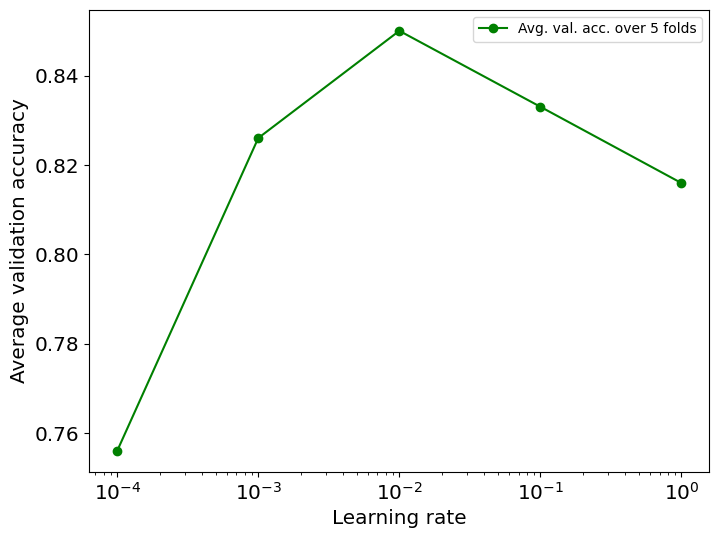

In [20]:
# Plotting
size = 'x-large'
fig, ax = plt.subplots(figsize=(8, 6))

# ax.set_title('Performance comparison for different hyperparameters', fontsize=size)
ax.semilogx(learning_rate, avg_val_acc_lr, 'go-', label='Avg. val. acc. over 5 folds')
ax.set_xlabel('Learning rate', fontsize=size)
ax.set_ylabel('Average validation accuracy', fontsize=size)
ax.tick_params(axis='both', labelsize=size)
# ax1.grid(axis='both')
ax.legend()

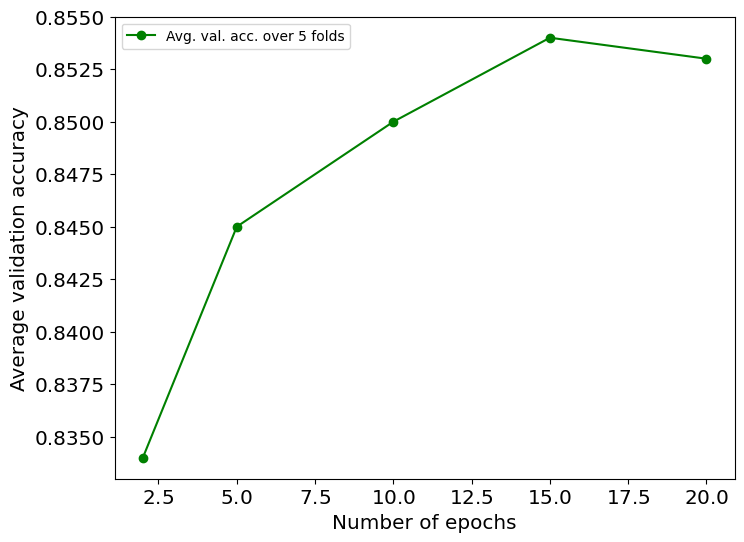

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(epochs, avg_val_acc_ep, 'go-', label='Avg. val. acc. over 5 folds')
ax.set_xlabel('Number of epochs', fontsize=size)
ax.set_ylabel('Average validation accuracy', fontsize=size)
ax.tick_params(axis='both', labelsize=size)
ax.legend()

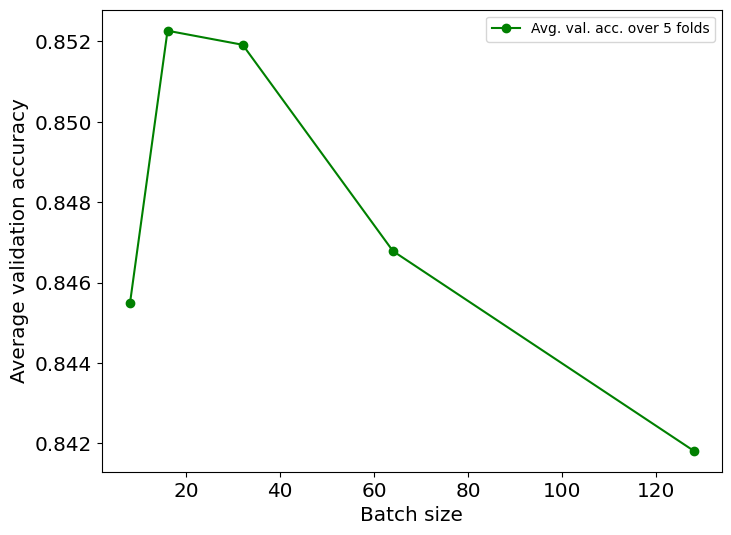

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(batch_size, avg_val_acc_bs, 'go-', label='Avg. val. acc. over 5 folds')
ax.set_xlabel('Batch size', fontsize=size)
ax.set_ylabel('Average validation accuracy', fontsize=size)
ax.tick_params(axis='both', labelsize=size)
ax.legend()

# plt.savefig('NTasnim-HW4-6b.pdf', bbox_inches='tight')

# Training with best hyperparameters

In [ ]:
# Hyperparameters
learning_rate = 0.01
epochs = 15
batch_size = 16

# Split training set into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Instantiate the model
model = LogisticRegression(input_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop with validation
for epoch in range(epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 1000 == 0:
            print(f'Training - Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            # Move data to GPU
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# Evaluation on test set

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

In [1]:
# Code for precision, recall, F1-score, ROC-AUC curve etc. goes here
"""How to do confidence interval? Bootstrapping on 60k training data is infeasible."""
# To discuss

'How to do confidence interval? Bootstrapping on 60k training data is infeasible.'

***Extra:*** *Results on other sets of hyperparameters*

LR = 0.01, Epoch = 10, BS = 32

Validation Accuracy: 85.33%

Test Accuracy: 84.01%

---
LR = 0.01, Epoch = 15, BS = 32

Validatio Accuracy: 85.66%

Test Accuracy: 83.50%